In [1]:
import sys
from latent_circuit_inference.utils.plotting_functions import plot_connectivity
from latent_circuit_inference.utils.utils import set_paths
sys.path.append("../experimental/")
sys.path.append("../")
sys.path.append("../../")
from pathlib import Path
import numpy as np
import json
import os
import torch
import trainRNNbrain
from trainRNNbrain.training.training_utils import prepare_task_arguments, get_training_mask
from trainRNNbrain.rnns.RNN_torch import *
from trainRNNbrain.rnns.RNN_numpy import *
from trainRNNbrain.tasks.TaskCDDM import TaskCDDM
from trainRNNbrain.datasaver.DataSaver import *
from latent_circuit_inference.LatentCircuit import LatentCircuit
from latent_circuit_inference.LatentCircuitFitter import *
from latent_circuit_inference.LCAnalyzer import *
from matplotlib import pyplot as plt

python: can't open file '../../style/style_setup.py': [Errno 2] No such file or directory
python: can't open file '../../style/style_setup.py': [Errno 2] No such file or directory


In [2]:
RNN_parent_folder = "./data"
RNN_subfolder = "0.0068407_CDDM_relu;N=94;lmbdo=0.3;orth_inp_only=True;lmbdr=0.5;lr=0.005;maxiter=5000"
taskname = "CDDM"
activation_name = "relu"
activation_slope = 1.0
constrained = True

In [3]:
tag = f"{activation_name}_constrained={constrained}"
dt = 1 # Euler step
tau = 10 # Dynamics time constant in tau dx/dt = - x  + f(W_rec x + W_inp (u + input_noise)) + recurrent_noise
sigma_rec =  .05 # variance of the recurrent noise
sigma_inp = .05 # variance of the input noise
device = "cpu"
N = 8 # number of units in the latent circuit
n_inputs = 6
n_outputs = 2

In [6]:
# defining the CDDM task (the same parameters used for training the original RNN)
n_steps = 300
cue_on = 0
cue_off = 300
stim_on = 100
stim_off = 300
dec_on = 200
dec_off = 300
coherences = np.linspace(-1, 1, 15)
print(f"Coherences: {[np.round(coherence, 2) for coherence in coherences]}")
task = TaskCDDM(n_steps, n_inputs, n_outputs, cue_on, cue_off, stim_on, stim_off, dec_on, dec_off, coherences)

Coherences: [-1.0, -0.86, -0.71, -0.57, -0.43, -0.29, -0.14, 0.0, 0.14, 0.29, 0.43, 0.57, 0.71, 0.86, 1.0]


In [9]:
# defining RNN
def get_RNN_conf(path):
    files = os.listdir(path)
    for file in files:
        if "_config" in file:
            if "yaml" in file:
                RNN_conf = OmegaConf.load(os.path.join(path, file))
            elif "json" in file:
                RNN_conf = json.load(open(os.path.join(path, file), "rb+"))
            break
    return RNN_conf

def get_RNN_data(path):
    files = os.listdir(path)
    for file in files:
        if "_params_" in file:
            rnn_data = json.load(open(os.path.join(path, file), "rb+"))
            break
    return rnn_data

RNN_conf = get_RNN_conf(os.path.join(RNN_parent_folder, RNN_subfolder))
rnn_data = get_RNN_data(os.path.join(RNN_parent_folder, RNN_subfolder))

RNN_params = {"W_inp": np.array(rnn_data["W_inp"]),
              "W_rec": np.array(rnn_data["W_rec"]),
              "W_out": np.array(rnn_data["W_out"]),
              "bias_rec": None if rnn_data["bias_rec"] is None else np.array(rnn_data["bias_rec"]),
              "y_init": np.zeros(rnn_data["N"]),
              "activation_name": activation_name,
              "activation_slope": activation_slope}
# defining numpy RNN (lightweight numpy class for analysis)
for key in ["N", "dt", "tau"]:
    RNN_params[key] = rnn_data[key]
N_RNN = rnn_data["N"]
RNN = RNN_numpy(**RNN_params)
RNN.y = np.zeros(N_RNN)

Input shape (n_inputs, n_steps, K): (6, 300, 450)
Output shape (n_outputs, n_steps, K): (2, 300, 450)


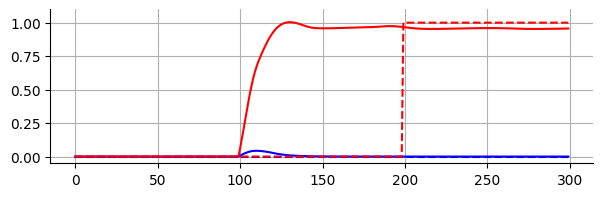

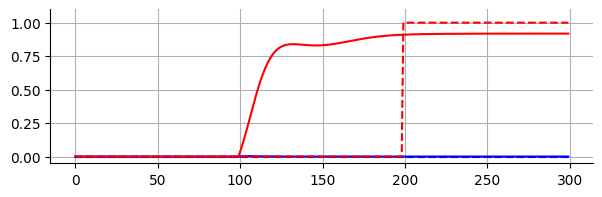

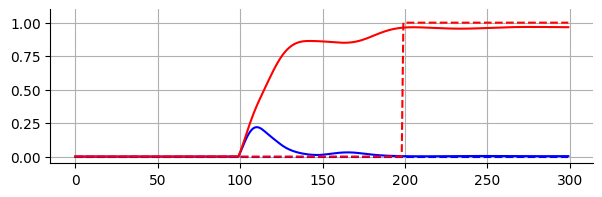

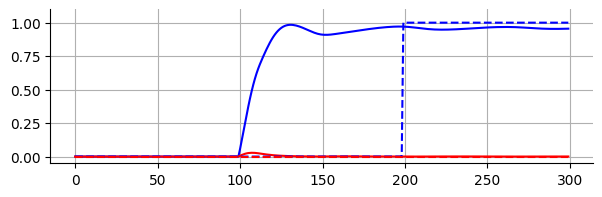

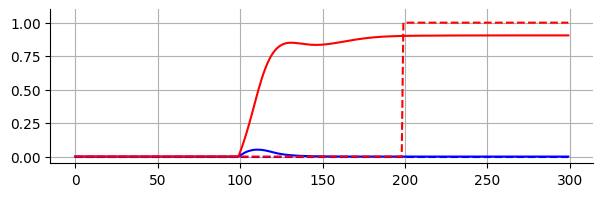

In [10]:
# Running the dynamics of the RNN, making sure that it performs the task well
inputs, targets, conditions = task.get_batch()

RNN.clear_history()
RNN.run(inputs)
outputs = RNN.get_output()

K = inputs.shape[-1] # K is the number of trials
print(f"Input shape (n_inputs, n_steps, K): {inputs.shape}")
print(f"Output shape (n_outputs, n_steps, K): {outputs.shape}")

for i in range(5):
    # plot a random trial
    trial_index = np.random.randint(K)
    fig = plt.figure(figsize=(7, 2))
    ax = fig.add_subplot(111)  # Create an Axes object
    
    # Plot your data
    ax.plot(outputs[0, :, trial_index], color='blue', linestyle='-')
    ax.plot(outputs[1, :, trial_index], color='red', linestyle='-')
    ax.plot(targets[0, :, trial_index], color='blue', linestyle='--')
    ax.plot(targets[1, :, trial_index], color='red', linestyle='--')
    ax.set_ylim([-0.05, 1.1])
    # Remove upper and right spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.grid(True)
    plt.show()

In [13]:
seed = np.random.randint(1000000)
print(f"seed: {seed}")
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
rng = torch.Generator(device=torch.device(device))
if not seed is None:
    rng.manual_seed(seed)

seed: 989403


In [14]:
# definint RNN in torch (for inferring the circuit with autograd)
rnn_torch = RNN_torch(N=rnn_data["N"],
                      dt=rnn_data["dt"], tau=rnn_data["tau"],
                      exc_to_inh_ratio=RNN_conf["model"]["exc_to_inh_ratio"],
                      input_size=np.array(rnn_data["W_inp"]).shape[1],
                      output_size=np.array(rnn_data["W_out"]).shape[0],
                      activation_name=activation_name,
                      activation_slope=activation_slope,
                      seed=seed,
                      sigma_rec=RNN_conf["model"]["sigma_rec"],
                      sigma_inp=RNN_conf["model"]["sigma_inp"])
rnn_torch.set_params(RNN_params)

Using cpu for RNN!


In [15]:
# initialization of circuit's input connectivity
w_inp = [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
# initialization of circuit's  output connectivity
w_out = [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
        [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]
# setting which input weights are allowed to change
inp_connectivity_mask = [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
                        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
# setting which recurrent weights are allowed to change (in this example, all of them)
rec_connectivity_mask = [[ 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
                        [ 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
                        [ 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
                        [ 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
                        [ 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
                        [ 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
                        [ 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
                        [ 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]
# setting which output weights are allowed to change (in this example, all of them)
out_connectivity_mask = [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
                        [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]

In [17]:
# defining LC circuit
lc = LatentCircuit(N,
                   activation_name,
                   activation_slope,
                   w_inp,
                   w_out,
                   w_rec=None,
                   dt=dt,
                   tau=tau,
                   num_inputs=n_inputs,
                   num_outputs=n_outputs,
                   sigma_rec=sigma_rec,
                   sigma_inp=sigma_inp,
                   rec_connectivity_mask=rec_connectivity_mask,
                   inp_connectivity_mask=inp_connectivity_mask,
                   out_connectivity_mask=out_connectivity_mask,
                   dale_mask=None,
                   random_generator=rng,
                   device=device)

Using cpu for Latent Circuit!


In [18]:
# defining LC_fitter

# we project the traces of the original RNN down to N_PCs first preserving > 99.9% of the variance
# and we fit the traces of the circuit into the projected N_PC-dimensional traces instead of full N_RNN-dimensional traces
N_PCs = 30 

# one can either embed the small-circuit traces into the large RNN space (encoding) 
# or project the RNN spaces down to N_circuit dimensions, and compare it there (decoding)
encoding = True 

max_iter = 1000
tol = 1e-12
lr = 0.02

# regularization on weights
lambda_w = 0.02

# weather to use preinitialized Q matrix or not
Qinitialization = False

criterion = torch.nn.MSELoss()
fitter = LatentCircuitFitter(LatentCircuit=lc,
                             RNN=rnn_torch,
                             Task=task,
                             N_PCs=N_PCs,
                             encoding=encoding,
                             max_iter=max_iter,
                             tol=tol,
                             lr=lr,
                             criterion=criterion,
                             lambda_w=lambda_w,
                             Qinitialization=Qinitialization)

Latent Circuit Fitter device cpu
setting projection of RNN traces on the lower subspace


/Users/tolmach/Documents/GitHub/latent_circuit_inference/jupyter/../latent_circuit_inference/LatentCircuitFitter.py:121: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.RNN.sigma_rec = torch.tensor(sigma_rec, device=self.device)
/Users/tolmach/Documents/GitHub/latent_circuit_inference/jupyter/../latent_circuit_inference/LatentCircuitFitter.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.RNN.sigma_inp = torch.tensor(sigma_inp, device=self.device)


In [19]:
#Running the inference (takes some time while running on cpu)
lc_inferred, train_losses, val_losses, lc_params = fitter.run_training()

/Users/tolmach/Documents/GitHub/latent_circuit_inference/jupyter/../latent_circuit_inference/LatentCircuitFitter.py:164: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.LatentCircuit.input_layer.weight.data *= torch.tensor(self.LatentCircuit.input_layer.weight.data > 0)
/Users/tolmach/Documents/GitHub/latent_circuit_inference/jupyter/../latent_circuit_inference/LatentCircuitFitter.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.LatentCircuit.output_layer.weight.data *= torch.tensor(self.LatentCircuit.output_layer.weight.data > 0)


iteration 0, train loss: 5.461964, validation loss: 3.407707
iteration 1, train loss: 4.105668, validation loss: 2.633079
iteration 2, train loss: 3.161966, validation loss: 2.075127
iteration 3, train loss: 2.49941, validation loss: 1.667867
iteration 4, train loss: 1.99901, validation loss: 1.361025
iteration 5, train loss: 1.640898, validation loss: 1.125379
iteration 6, train loss: 1.363818, validation loss: 0.943962
iteration 7, train loss: 1.147552, validation loss: 0.800988
iteration 8, train loss: 0.977882, validation loss: 0.686824
iteration 9, train loss: 0.840667, validation loss: 0.594982
iteration 10, train loss: 0.735887, validation loss: 0.520679
iteration 11, train loss: 0.646301, validation loss: 0.460083
iteration 12, train loss: 0.574575, validation loss: 0.41037
iteration 13, train loss: 0.51598, validation loss: 0.369277
iteration 14, train loss: 0.466198, validation loss: 0.335072
iteration 15, train loss: 0.42512, validation loss: 0.306467
iteration 16, train los

In [20]:
# defining circuit
circuit_building_params = {key: lc_params[key] for key in lc_params.keys() if key not in ["q", "U"]}
circuit = RNN_numpy(**circuit_building_params)
circuit.y = np.zeros(N)

# defining numpy RNN
RNN_building_params = RNN_params
for key in ["N", "dt", "tau"]:
    RNN_building_params[key] = rnn_data[key]
N_RNN = rnn_data["N"]
RNN = RNN_numpy(**RNN_params)
RNN.y = np.zeros(N_RNN)

U = lc_params["U"] # projection matrix from N_RNN to N_PC
q = lc_params["q"] # embedding matrix from N_LC to N_PC
Q = U.T @ q # full embedding matrix from N_LC to N_RNN
w_rec_bar = Q.T @ RNN_params["W_rec"] @ Q
node_labels = np.arange(lc_params["W_rec"].shape[0])
analyzer = LCAnalyzer(circuit, labels=node_labels)

input_batch_valid, target_batch_valid, conditions_valid = task.get_batch()
mask = np.concatenate([np.arange(stim_on), dec_on + np.arange(dec_off - dec_on)])

#MSE mse_score_RNN
score_function = lambda x, y: np.mean((x - y) ** 2)
mse_score = analyzer.get_validation_score(scoring_function=score_function,
                                          input_batch=input_batch_valid,
                                          target_batch=target_batch_valid,
                                          mask=mask,
                                          sigma_rec=sigma_rec,
                                          sigma_inp=sigma_inp)
mse_score = np.round(mse_score, 8)
print(f"MSE: {mse_score}")

MSE: 0.01917344


In [24]:
# Computing total variance explained
batch_size = input_batch_valid.shape[2]
RNN.clear_history()
circuit.clear_history()

RNN.run(input_timeseries=input_batch_valid, sigma_rec=0, sigma_inp=0)
RNN_trajectories = RNN.get_history()
RNN_output = RNN.get_output()

circuit.run(input_timeseries=input_batch_valid, sigma_rec=0, sigma_inp=0)
lc_trajectories = circuit.get_history()
lc_output = circuit.get_output()

lc_trajectories_emb = np.einsum("ji, ikp->jkp", Q, lc_trajectories)
RNN_trajectories_proj = np.einsum("ij, ikp->jkp", Q, RNN_trajectories)
r2_tot = np.nanmean([R2(lc_trajectories_emb[:, mask, i], RNN_trajectories[:, mask, i]) for i in range(batch_size)])
r2_proj = np.nanmean([R2(lc_trajectories[:, mask, i], RNN_trajectories_proj[:, mask, i]) for i in range(batch_size)])
print(f"Total R2: {np.round(r2_tot, 2)}")
print(f"Projected R2: {np.round(r2_proj, 2)}")
scores = {"mse_score": np.round(mse_score, 3), "r2_tot": np.round(r2_tot, 2), "r2_proj" : np.round(r2_proj, 2)}
print(scores)

Total R2: 0.78
Projected R2: 0.81
{'mse_score': 0.019, 'r2_tot': 0.78, 'r2_proj': 0.81}


In [25]:
data_save_folder = os.path.join("./data", RNN_subfolder, f"{r2_tot}_{r2_proj}_LC_{tag}")
datasaver = DataSaver(data_save_folder)
datasaver.save_data(scores, f"{r2_tot}_{r2_proj}_LC_scores.json")
datasaver.save_data(jsonify(lc_params), f"LC_params.json")
datasaver.save_data(jsonify(RNN_params), f"RNN_params.json")

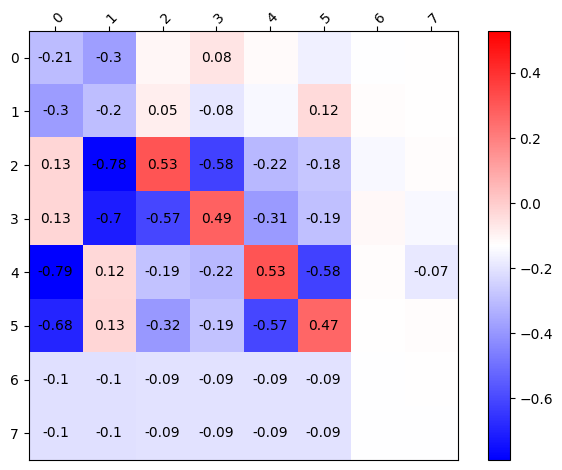

In [26]:
# plotting inferred recurrent connectivity
fig_w_rec = analyzer.plot_recurrent_matrix()
datasaver.save_figure(fig_w_rec, f"{r2_tot}_{r2_proj}_LC_wrec.png")
plt.show()

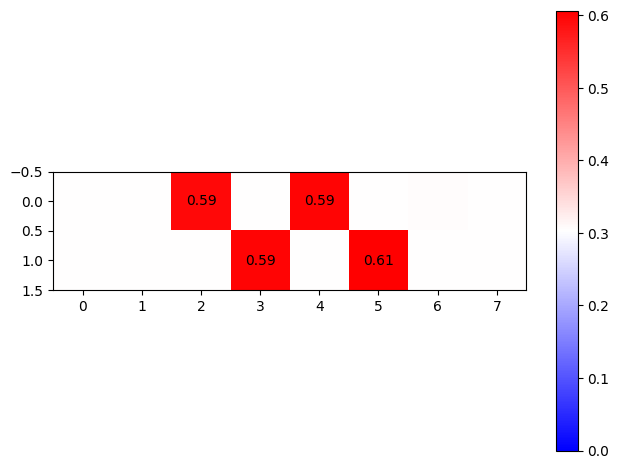

In [27]:
# plotting output matrix
fig_w_out = analyzer.plot_output_matrix()
datasaver.save_figure(fig_w_out, f"{r2_tot}_{r2_proj}_LC_wout.png")
plt.show()

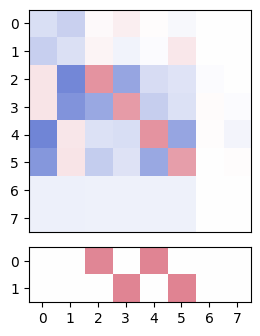

In [28]:
path = os.path.join(data_save_folder, "connectivity.pdf")
plot_connectivity(circuit.W_inp, circuit.W_rec, circuit.W_out,
                  show_inp=False, show_values=False,
                  show=True,
                  save=False,
                  path=path)

Plotting random trials


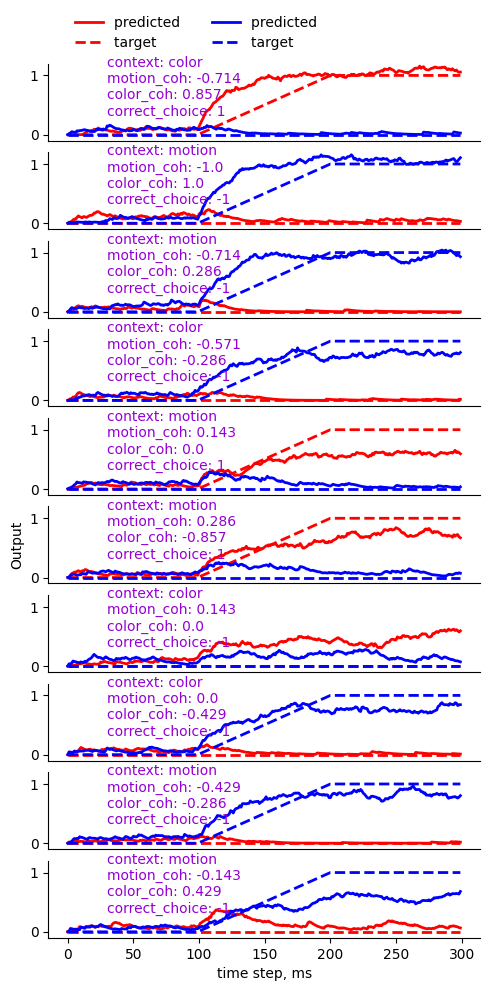

In [29]:
print(f"Plotting random trials")
inds = np.random.choice(np.arange(input_batch_valid.shape[-1]), 10)
inputs = input_batch_valid[..., inds]
targets = target_batch_valid[..., inds]
conditions = [conditions_valid[ind] for ind in inds]
fig_trials = analyzer.plot_trials(inputs, targets, mask,
                                  conditions=conditions,
                                  sigma_rec=sigma_rec, sigma_inp=sigma_inp)
datasaver.save_figure(fig_trials, f"{r2_tot}_{r2_proj}_LC_random_trials.png")
plt.show()